In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

from xgboost import XGBRegressor

In [54]:
dataset = pd.read_csv('insurance.csv')
dataset.tail()


,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [55]:
dataset.describe(include="all")

,age,sex,bmi,children,smoker,region,expenses
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.665471,1.094918,NaN,NaN,13270.422414
std,14.049960,NaN,6.098382,1.205493,NaN,NaN,12110.011240
min,18.000000,NaN,16.000000,0.000000,NaN,NaN,1121.870000
25%,27.000000,NaN,26.300000,0.000000,NaN,NaN,4740.287500
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.030000
75%,51.000000,NaN,34.700000,2.000000,NaN,NaN,16639.915000


In [56]:
dataset['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [57]:
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

# exploring more the dataset

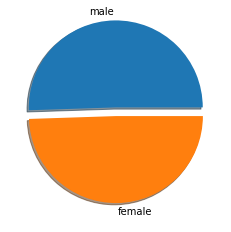

In [58]:
len_sex_male=dataset["sex"][dataset.sex=="male"]
len_sex_female=dataset["sex"][dataset.sex=="female"]
arr=np.array([len(len_sex_male),len(len_sex_female)])
labels=["male","female"]
plt.pie(arr,labels=labels,explode=[0.1,0.0],shadow=True)
plt.show()

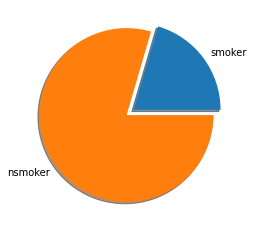

In [59]:
len_smoker=dataset["smoker"][dataset.smoker=="yes"]
len_no_smoker=dataset["smoker"][dataset.smoker=="no"]
arr=np.array([len(len_smoker),len(len_no_smoker)])
labels=["smoker","nsmoker"]
plt.pie(arr,labels=labels,explode=[0.1,0.0],shadow=True)
plt.show()

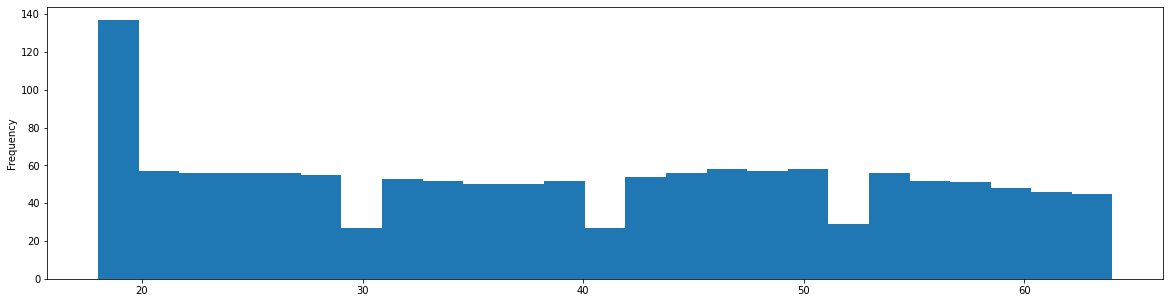

In [60]:
dataset.age.plot(kind='hist', bins=25, figsize=(20,5));

<AxesSubplot:ylabel='Frequency'>

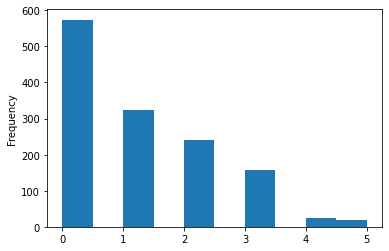

In [61]:
dataset.children.plot(kind='hist')

In [62]:
df_dummies = pd.get_dummies(dataset, columns=['sex', 'smoker', 'region', 'children'], drop_first=True)
df_dummies.head()

,age,bmi,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,children_1,children_2,children_3,children_4,children_5
0,19,27.9,16884.92,0,1,0,0,1,0,0,0,0,0
1,18,33.8,1725.55,1,0,0,1,0,1,0,0,0,0
2,28,33.0,4449.46,1,0,0,1,0,0,0,1,0,0
3,33,22.7,21984.47,1,0,1,0,0,0,0,0,0,0
4,32,28.9,3866.86,1,0,1,0,0,0,0,0,0,0


In [63]:
y, X = np.log10(df_dummies.loc[:,'expenses']), df_dummies.drop(['expenses'], axis=1)

# converting categorical data to numbers (sex , region and smoker)

In [64]:
dataset['sex']=dataset.sex.map({"male":0,"female":1})
dataset['smoker']=dataset.smoker.map({"no":0,"yes":1})
dataset['region']=dataset.region.map({"southeast":0,"northwest":1,"northeast":2,"southwest":3})
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,1,27.9,0,1,3,16884.92
1,18,0,33.8,1,0,0,1725.55
2,28,0,33.0,3,0,0,4449.46
3,33,0,22.7,0,0,1,21984.47
4,32,0,28.9,0,0,1,3866.86


# spliting data

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
print('X_train shape ',X_train.shape)
print('X_test shape ',X_test.shape)
print('y_train shape ',y_train.shape)
print('y_test shape ',y_test.shape)

X_train shape  (1070, 12)
X_test shape  (268, 12)
y_train shape  (1070,)
y_test shape  (268,)


In [66]:
def print_scores(regressor, X_train, y_train, X_test, y_test):
    """
    This function uses supplied regressor algorithms to train a model and predict
    the target value.
    Ultimately the accuracy and other scoring parameters (R^2, MSE, RMSE, LRMSE, MAE) are shown
    """
    regressor.fit(X_train, y_train)
    y_prediction = regressor.predict(X_test)
    accuracy = accuracy_score(y_true = y_test.astype(int), y_pred = y_prediction.astype(int))
    print('Variance-score (R^2): {0:.4f}'.format(regressor.score(X_test, y_test)))
    print('Mean squared error: {0:.4f}'.format(np.mean((regressor.predict(X_test) - y_test) ** 2)))
    print('Root mean squared error: {0:.4f}'.format(np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))))
    print('log root mean squared error: {0:.4f}'.format(np.sqrt(np.square(np.log10(y_prediction + 1) - np.log10(y_test + 1)).mean())))
    print('mean absolute error: {0:.4f}'.format(mean_absolute_error(y_test, y_prediction)))
    print('Accuracy: {0:.2f}%'.format(accuracy*100))
    return

In [67]:
print_scores(LinearRegression(), X_train, y_train, X_test, y_test)

Variance-score (R^2): 0.8060
Mean squared error: 0.0329
Root mean squared error: 0.1814
log root mean squared error: 0.0160
mean absolute error: 0.1192
Accuracy: 92.16%


In [68]:
print_scores(Lasso(), X_train, y_train, X_test, y_test)

Variance-score (R^2): 0.2709
Mean squared error: 0.1237
Root mean squared error: 0.3516
log root mean squared error: 0.0311
mean absolute error: 0.2821
Accuracy: 73.51%


In [69]:
print_scores(Ridge(alpha=0.1, normalize=True), X_train, y_train, X_test, y_test)


Variance-score (R^2): 0.7941
Mean squared error: 0.0349
Root mean squared error: 0.1869
log root mean squared error: 0.0167
mean absolute error: 0.1289
Accuracy: 92.54%


In [70]:
regressor = XGBRegressor()
print_scores(regressor, X_train, y_train, X_test, y_test)

Variance-score (R^2): 0.8146
Mean squared error: 0.0314
Root mean squared error: 0.1773
log root mean squared error: 0.0158
mean absolute error: 0.0938
Accuracy: 91.04%


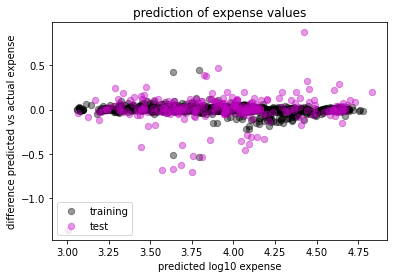

In [71]:
plt.scatter(regressor.predict(X_train), regressor.predict(X_train) - y_train, c='black', s=40, label='training', alpha=0.4)
plt.scatter(regressor.predict(X_test), regressor.predict(X_test) - y_test, c='m', s=40, label='test', alpha=0.4)
plt.legend(loc='lower left')
plt.title('prediction of expense values')
plt.xlabel('predicted log10 expense')
plt.ylabel('difference predicted vs actual expense');
#plt.savefig('expense_prediction.png')

In [72]:
def evaluate_model_on_mae(model, X_test, y_test):
    """
    helper function to return the models mean absolute error for the predictions
    Parameters
      ----------
      model: regression model 
      X_test: test data in tabular format
      y_test: expected target values
      Returns
      ---------
      mean absolute error using sklearn.metrics mean_absolute_error method
      """
    y_prediction = model.predict(X_test)
    return mean_absolute_error(y_test, y_prediction)

In [73]:
mae = evaluate_model_on_mae(regressor, X_test, y_test)

In [74]:
if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")




You passed the challenge. Great job!
